# 1/ Import libraries

In [90]:
import pandas as pd
import pandas._typing
import numpy as np
import mlflow
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from typing import cast
from sklearn.exceptions import NotFittedError
from sklearn.utils.validation import check_is_fitted
from IPython.display import display
from pathlib import Path
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.dummy import DummyClassifier


# 2/ Dataset Exploration

In [91]:
# Load the datasets
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")

In [92]:
# Combine the test and train datasets for consistent preprocessing
combine = pd.concat([test, train], axis=0)

In [93]:
# View the first few rows of the combined dataset
combine.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2,NaN
1,58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4,NaN
2,58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2,NaN
3,58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7,NaN
4,58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4,NaN


In [94]:
# Display information about the dataset
combine.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97743 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          97743 non-null  int64  
 1   person_age                  97743 non-null  int64  
 2   person_income               97743 non-null  int64  
 3   person_home_ownership       97743 non-null  object 
 4   person_emp_length           97743 non-null  float64
 5   loan_intent                 97743 non-null  object 
 6   loan_grade                  97743 non-null  object 
 7   loan_amnt                   97743 non-null  int64  
 8   loan_int_rate               97743 non-null  float64
 9   loan_percent_income         97743 non-null  float64
 10  cb_person_default_on_file   97743 non-null  object 
 11  cb_person_cred_hist_length  97743 non-null  int64  
 12  loan_status                 58645 non-null  float64
dtypes: float64(4), int64(5), object(4)
m

In [95]:
# Generate summary statistics for numerical columns
combine.describe()

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,97743.000000,97743.000000,9.774300e+04,97743.000000,97743.000000,97743.000000,97743.000000,97743.000000,58645.000000
mean,48871.000000,27.557227,6.405189e+04,4.695436,9231.120663,10.671211,0.159372,5.820417,0.142382
std,28216.118018,6.033008,3.794080e+04,3.923469,5568.786009,3.028910,0.091668,4.046423,0.349445
min,0.000000,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,24435.500000,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,48871.000000,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000,0.000000
75%,73306.500000,30.000000,7.574400e+04,7.000000,12000.000000,12.990000,0.210000,8.000000,0.000000
max,97742.000000,123.000000,1.900000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


In [96]:
combine.dropna()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0.0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0.0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0.0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0.0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
58640,58640,34,120000,MORTGAGE,5.0,EDUCATION,D,25000,15.95,0.21,Y,10,0.0
58641,58641,28,28800,RENT,0.0,MEDICAL,C,10000,12.73,0.35,N,8,1.0
58642,58642,23,44000,RENT,7.0,EDUCATION,D,6800,16.00,0.15,N,2,1.0
58643,58643,22,30000,RENT,2.0,EDUCATION,A,5000,8.90,0.17,N,3,0.0


# a) Data Cleaning

In [97]:
# Fill missing values in numerical columns with the column mean
filled = combine.fillna(combine.mean(numeric_only=True))
filled

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2,0.142382
1,58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4,0.142382
2,58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2,0.142382
3,58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7,0.142382
4,58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4,0.142382
...,...,...,...,...,...,...,...,...,...,...,...,...,...
58640,58640,34,120000,MORTGAGE,5.0,EDUCATION,D,25000,15.95,0.21,Y,10,0.000000
58641,58641,28,28800,RENT,0.0,MEDICAL,C,10000,12.73,0.35,N,8,1.000000
58642,58642,23,44000,RENT,7.0,EDUCATION,D,6800,16.00,0.15,N,2,1.000000
58643,58643,22,30000,RENT,2.0,EDUCATION,A,5000,8.90,0.17,N,3,0.000000


In [98]:
# Remove duplicates in the dataset
no_duplicates = filled.drop_duplicates()
no_duplicates

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2,0.142382
1,58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4,0.142382
2,58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2,0.142382
3,58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7,0.142382
4,58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4,0.142382
...,...,...,...,...,...,...,...,...,...,...,...,...,...
58640,58640,34,120000,MORTGAGE,5.0,EDUCATION,D,25000,15.95,0.21,Y,10,0.000000
58641,58641,28,28800,RENT,0.0,MEDICAL,C,10000,12.73,0.35,N,8,1.000000
58642,58642,23,44000,RENT,7.0,EDUCATION,D,6800,16.00,0.15,N,2,1.000000
58643,58643,22,30000,RENT,2.0,EDUCATION,A,5000,8.90,0.17,N,3,0.000000


# b) Import the combine dataset

In [99]:
# Exporter le DataFrame vers un fichier CSV
combine.to_csv('All_data.csv', index=False)

# C) Plotting variables

In [100]:
df = pd.read_csv("All_data.csv")

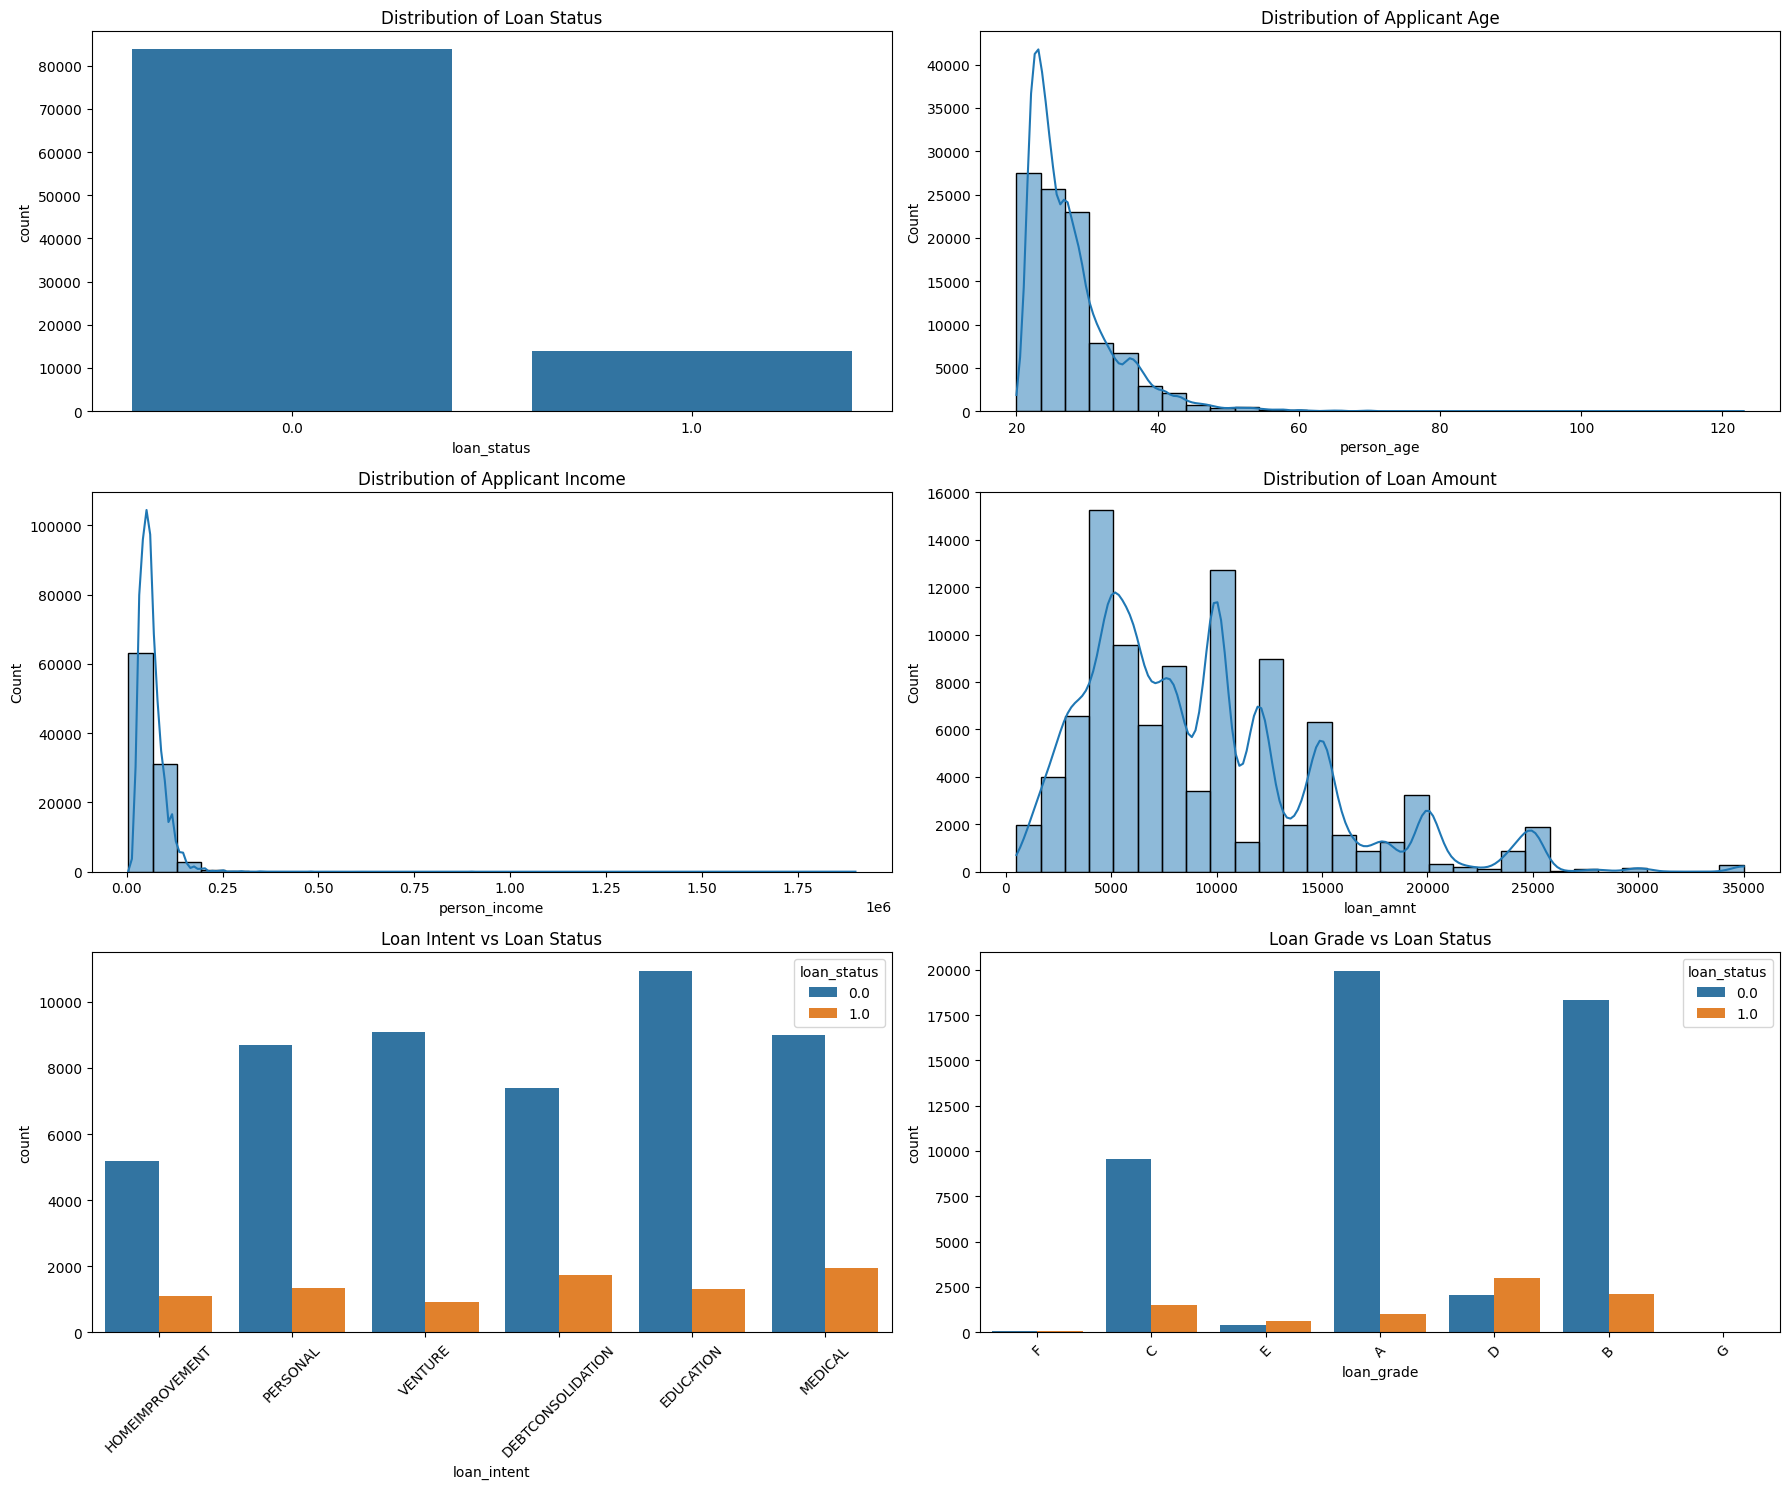

In [101]:
# Set up the plotting environment
plt.figure(figsize=(18, 15))

# Distribution of the target variable (loan_status)
plt.subplot(3, 2, 1)
sns.countplot(x='loan_status', data=combine)
plt.title('Distribution of Loan Status')

# Age distribution
plt.subplot(3, 2, 2)
sns.histplot(df['person_age'], kde=True, bins=30)
plt.title('Distribution of Applicant Age')

# Income distribution
plt.subplot(3, 2, 3)
sns.histplot(df['person_income'], kde=True, bins=30)
plt.title('Distribution of Applicant Income')

# Loan amount distribution
plt.subplot(3, 2, 4)
sns.histplot(df['loan_amnt'], kde=True, bins=30)
plt.title('Distribution of Loan Amount')

# Loan intent vs. Loan status (increased figure size and rotated labels)
plt.subplot(3, 2, 5)
sns.countplot(x='loan_intent', hue='loan_status', data=combine)
plt.title('Loan Intent vs Loan Status')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability

# Loan grade vs. Loan status
plt.subplot(3, 2, 6)
sns.countplot(x='loan_grade', hue='loan_status', data=combine)
plt.title('Loan Grade vs Loan Status')
plt.xticks(rotation=45)  # Rotate x-axis labels here as well for better readability
df['loan_grade'] = pd.Categorical(df['loan_grade'], categories=['A', 'B', 'C', 'D', 'E', 'F', 'G'], ordered=True)

plt.tight_layout()
plt.show()


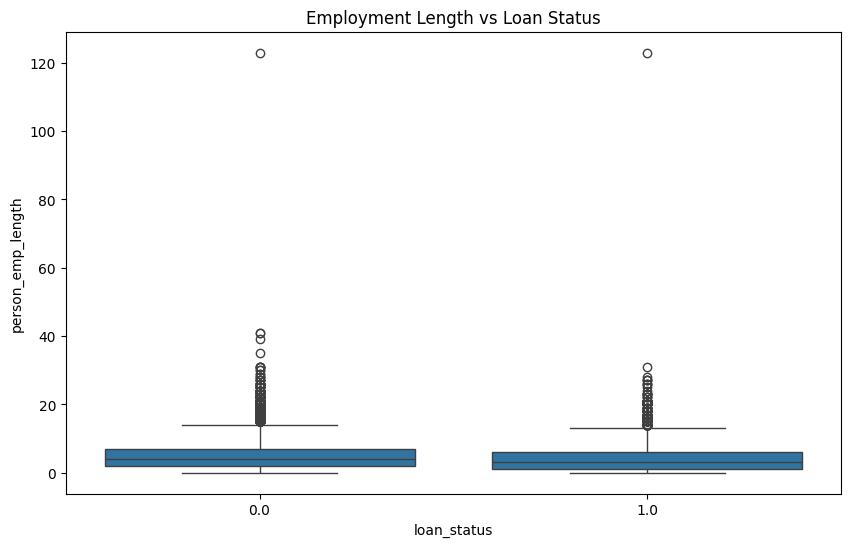

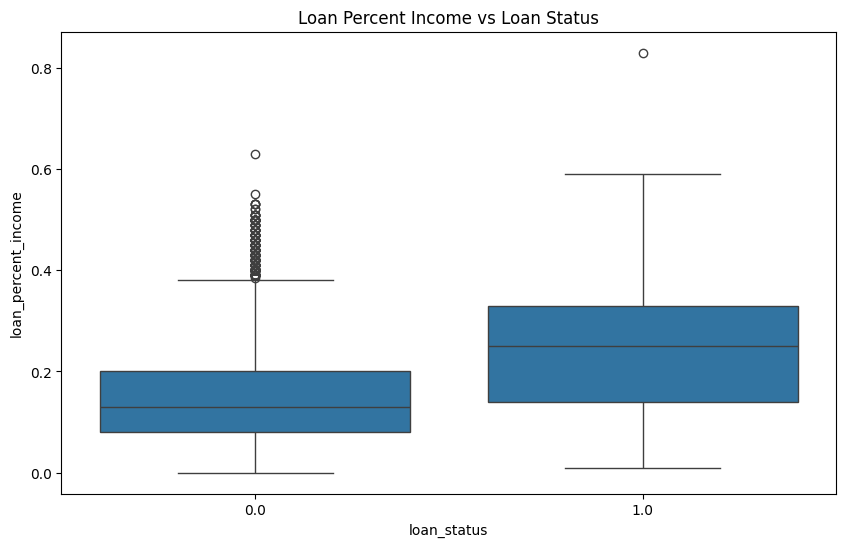

In [102]:
# Visualize the relationship between employment length and loan status using a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='loan_status', y='person_emp_length', data=df)
plt.title('Employment Length vs Loan Status')
plt.show()

# Visualize the relationship between loan percent income and loan status using a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='loan_status', y='loan_percent_income', data=df)
plt.title('Loan Percent Income vs Loan Status')
plt.show()

# d) Conversion of categorical variables and correlation matrix

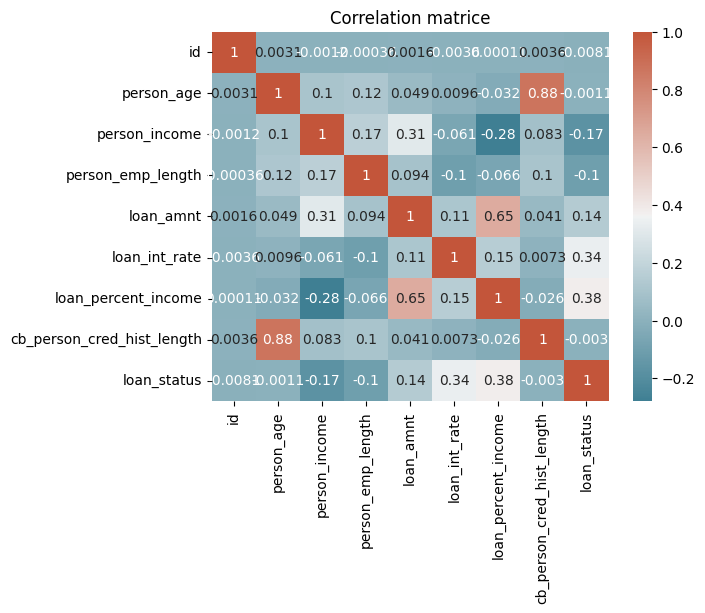

In [103]:
# Generate a correlation matrix for numerical features
Change = df.select_dtypes(include=['number'])
correlation = Change.corr()
sns.heatmap(correlation,xticklabels=correlation.columns, yticklabels=correlation.columns,annot=True, cmap=sns.diverging_palette(220,20,as_cmap=True))
plt.title("Correlation matrice")
plt.show()

# 3/ Baseline Machine Learning (Logistic Regression)

# a) Outliers detection

In [104]:
# Fonction pour vérifier la présence d'outliers
def has_outliers_iqr(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (column < lower_bound).any() or (column > upper_bound).any()

# Vérifier les outliers pour toutes les colonnes numériques
outlier_results = {column: has_outliers_iqr(df[column]) for column in df.select_dtypes(include='number').columns}

# Afficher le résultat
for column, has_outlier in outlier_results.items():
    print(f"Do we have outlier in column '{column}'? {'Yes' if has_outlier else 'No'}")

Do we have outlier in column 'id'? No
Do we have outlier in column 'person_age'? Yes
Do we have outlier in column 'person_income'? Yes
Do we have outlier in column 'person_emp_length'? Yes
Do we have outlier in column 'loan_amnt'? Yes
Do we have outlier in column 'loan_int_rate'? Yes
Do we have outlier in column 'loan_percent_income'? Yes
Do we have outlier in column 'cb_person_cred_hist_length'? Yes
Do we have outlier in column 'loan_status'? Yes


# b) Outliers suppression

In [105]:
# Fonction pour supprimer les outliers
def remove_outliers_iqr(df):
    for column in df.select_dtypes(include='number').columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        # Filtrer le DataFrame pour supprimer les outliers
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

# Supprimer les outliers
df_cleaned = remove_outliers_iqr(df)

df_cleaned

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
39099,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0.0
39100,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0.0
39101,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0.0
39102,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0.0
39103,5,27,45000,RENT,2.0,VENTURE,A,9000,8.94,0.20,N,5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
97734,58636,24,37000,RENT,3.0,EDUCATION,C,9000,13.49,0.24,Y,2,0.0
97735,58637,24,75000,RENT,8.0,VENTURE,B,4000,10.75,0.05,N,4,0.0
97737,58639,22,70000,RENT,6.0,DEBTCONSOLIDATION,A,10000,7.29,0.14,N,4,0.0
97741,58643,22,30000,RENT,2.0,EDUCATION,A,5000,8.90,0.17,N,3,0.0


# c) Train Test Split

In [115]:
df.shape

(74999, 13)

In [108]:
# Define features and target variable
X = df.drop(columns=['loan_status'])  # Features (all columns except the target)
y = df['loan_status']                  # Target variable

# Perform train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,            # 20% for testing
    random_state=42,          # For reproducibility
    stratify=y                # Ensures stratification
)

# Display the shapes of the resulting datasets
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (59999, 12) (59999,)
Testing set shape: (15000, 12) (15000,)


# d) Baseline (regression)

In [109]:
df.columns

Index(['id', 'person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length', 'loan_status'],
      dtype='object')

In [117]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [118]:
# Sélection des variables explicatives
X = df[['person_age', 'person_income', 'loan_amnt', 'loan_int_rate']]
y = df['loan_status']  # Assurez-vous que cette colonne est bien numérique

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Création du modèle de régression linéaire
model = LinearRegression()
model.fit(X_train, y_train)

# Prédictions
y_pred = model.predict(X_test)

# Évaluation du modèle
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R2 Score: {r2}')

# Coefficients du modèle
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
print(coefficients)

Mean Squared Error: 0.004949523859721326
R2 Score: 0.00630470143693429
                Coefficient
person_age     6.232063e-06
person_income -1.503157e-07
loan_amnt      6.126930e-07
loan_int_rate  1.430551e-03


In [110]:
# Séparation des caractéristiques et de la cible
X = df.drop(columns=['loan_status'])
y = df['loan_status']

# Split en train et test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Baseline : Prédiction de la moyenne
baseline_prediction = y_train.mean()
y_pred_baseline = [baseline_prediction] * len(y_test)

# Évaluation de la baseline
baseline_rmse = mean_squared_error(y_test, y_pred_baseline, squared=False)
print(f'Baseline RMSE: {baseline_rmse}')

Baseline RMSE: 0.07057575590367737


C:\Users\lucil\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# 4/ Iterations

In [111]:
from sklearn.linear_model import LinearRegression

# Remplacez le classificateur par un modèle de régression si nécessaire
reg_pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Assurez-vous que le préprocesseur est défini
    ('regressor', LinearRegression())
])

# Entraînez le modèle
reg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_length',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'loan_percent_income',
                                                   'cb_person_cred_hist_length']),
                                                 ('cat', OneHotEncoder(),
                                                  ['person_home_ownership',
                                                   'loan_intent', 'loan_grade',
                                                   'cb_person_default_on_file'])])),
                ('regressor', LinearRegression())])

In [112]:
# Convertir y_train en format catégorique si nécessaire
y_train = pd.Series(y_train).astype('category')

In [113]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

# Exemple avec un modèle de régression logistique
model = LogisticRegression()

# Validation croisée avec 5 plis
scores = cross_val_score(model, X, y, cv=5)
print(f"Scores de validation croisée : {scores}")
print(f"Moyenne des scores : {scores.mean()}")

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\lucil\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\lucil\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\lucil\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py", line 1223, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\lucil\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\lucil\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py", line 1301, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "C:\Users\lucil\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py", line 1012, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\lucil\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\_array_api.py", line 745, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\lucil\AppData\Roaming\Python\Python311\site-packages\pandas\core\generic.py", line 2153, in __array__
    arr = np.asarray(values, dtype=dtype)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: 'RENT'

--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\lucil\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\lucil\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\lucil\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py", line 1223, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\lucil\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\lucil\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py", line 1301, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "C:\Users\lucil\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py", line 1012, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\lucil\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\_array_api.py", line 745, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\lucil\AppData\Roaming\Python\Python311\site-packages\pandas\core\generic.py", line 2153, in __array__
    arr = np.asarray(values, dtype=dtype)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: 'MORTGAGE'


In [114]:
# Créer le préprocesseur
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),  # Normalisation des caractéristiques numériques
        ('cat', OneHotEncoder(), categorical_features)  # Encodage des caractéristiques catégorielles
    ]
)

# Créer le modèle et le pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

# Validation croisée avec 5 plis
scores = cross_val_score(model, X, y, cv=5)
print(f"Scores de validation croisée : {scores}")
print(f"Moyenne des scores : {scores.mean()}")

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\lucil\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\lucil\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\lucil\AppData\Roaming\Python\Python311\site-packages\sklearn\pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "C:\Users\lucil\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\lucil\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py", line 1231, in fit
    check_classification_targets(y)
  File "C:\Users\lucil\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\multiclass.py", line 219, in check_classification_targets
    raise ValueError(
ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.


In [80]:
print(X.dtypes)  # Affiche les types de données pour chaque colonne

id                              int64
person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length               int64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object


In [ ]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score


In [83]:
X = df.drop(columns=['loan_status', 'id'])  # On exclut 'loan_status' et 'id'
y = df['loan_status']

In [84]:
# Definir les colonnes numériques et catégorielles
numeric_features = [
    'person_age', 
    'person_income', 
    'person_emp_length', 
    'loan_amnt', 
    'loan_int_rate', 
    'loan_percent_income', 
    'cb_person_cred_hist_length'
]

categorical_features = [
    'person_home_ownership', 
    'loan_intent', 
    'loan_grade', 
    'cb_person_default_on_file'
]

In [85]:
# Créer le préprocesseur
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

# Créer le modèle et le pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

In [89]:
# Validation croisée avec 5 plis
scores = cross_val_score(model, X, y, cv=5)
print(f"Scores de validation croisée : {scores}")
print(f"Moyenne des scores : {scores.mean()}")

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\lucil\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\lucil\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\lucil\AppData\Roaming\Python\Python311\site-packages\sklearn\pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "C:\Users\lucil\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\lucil\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py", line 1231, in fit
    check_classification_targets(y)
  File "C:\Users\lucil\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\multiclass.py", line 219, in check_classification_targets
    raise ValueError(
ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.


Experiment Tracking